# Supervised Machine Learning

In [51]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

# Pickle
import joblib

In [52]:
# Import custom class
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/imputer.py'
%run -i '../src/helper/ml.py'

# Load data 

In [3]:
df = pd.read_csv('../data/hmeq.csv') # load data
print("Data size:", df.shape) # print data size
df.columns = [x.lower() for x in df.columns] # column names in lower case
df.head()

Data size: (5960, 13)


,bad,loan,mortdue,value,reason,job,yoj,derog,delinq,clage,ninq,clno,debtinc
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# Class distribution

In [4]:
df.bad.value_counts()/len(df)*100

0    80.050336
1    19.949664
Name: bad, dtype: float64

# Create feature matrix and class label

In [5]:
X,y = df.drop('bad', axis =1), df.bad

# Create a Test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

In [7]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (4768, 12) (4768,)
Test set size: (1192, 12) (1192,)


In [8]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('--' * 15)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    80.05453
1    19.94547
Name: bad, dtype: float64
------------------------------
Test set class distribution:
 0    80.033557
1    19.966443
Name: bad, dtype: float64


# Transformation pipeline

In [9]:
# Instantiate the  classes
transfxn = TransformationPipeline()
imputer = DataFrameImputer()

# 1. Impute missing values

In [10]:
# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.transform(X_test)

In [11]:
X_train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4768 entries, 609 to 2
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   loan     4768 non-null   int64  
 1   mortdue  4768 non-null   float64
 2   value    4768 non-null   float64
 3   reason   4768 non-null   object 
 4   job      4768 non-null   object 
 5   yoj      4768 non-null   float64
 6   derog    4768 non-null   float64
 7   delinq   4768 non-null   float64
 8   clage    4768 non-null   float64
 9   ninq     4768 non-null   float64
 10  clno     4768 non-null   float64
 11  debtinc  4768 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 484.2+ KB


# 2. Preprocessing

In [12]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_nm = transfxn.preprocessing(X_train_imputed, X_test_imputed)

In [13]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (4768, 18)
Test set size after pre-processing: (1192, 18)


In [14]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation

In [15]:
# Instantiate the class
model = SupervisedModels()

## A-0. Linear discriminant Analysis

In [56]:
lda_clf = LinearDiscriminantAnalysis(solver='svd')
model.model_selection_cv(lda_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.830745 (0.007185)
AUROC: 0.815611
AUPRC: 0.580986
Predicted classes: [0 1]
Confusion matrix:
 [[3605  212]
 [ 595  356]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      3817
           1       0.63      0.37      0.47       951

    accuracy                           0.83      4768
   macro avg       0.74      0.66      0.68      4768
weighted avg       0.81      0.83      0.81      4768

---------------------------------------------------------------------------


## A-1. Logistic Regression

In [16]:
log_clf = LogisticRegression()   
model.model_selection_cv(log_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.835568 (0.005726)
AUROC: 0.814436
AUPRC: 0.582830
Predicted classes: [0 1]
Confusion matrix:
 [[3659  158]
 [ 626  325]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      3817
           1       0.67      0.34      0.45       951

    accuracy                           0.84      4768
   macro avg       0.76      0.65      0.68      4768
weighted avg       0.82      0.84      0.81      4768

---------------------------------------------------------------------------


## Hyperparameter tuning - LR

In [17]:
# Range of hyperparameters
param_grid = {'C': [2**(x) for x in range(-2,9,2)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_lr = GridSearchCV(LogisticRegression(),param_grid, cv = 10,
                           scoring = 'roc_auc',verbose =1, n_jobs = -1)

# Fit the  training set
gsearch_lr.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_lr.best_estimator_, '../src/model/log_clf.pkl')

# Print results
print('Grid search best AUC score:', gsearch_lr.best_score_)
print('Grid search best parameters:', gsearch_lr.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.9s


Grid search best AUC score: 0.8142698339684669
Grid search best parameters: {'C': 0.25, 'class_weight': {0: 1, 1: 2}}


[Parallel(n_jobs=-1)]: Done 173 out of 180 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    4.3s finished


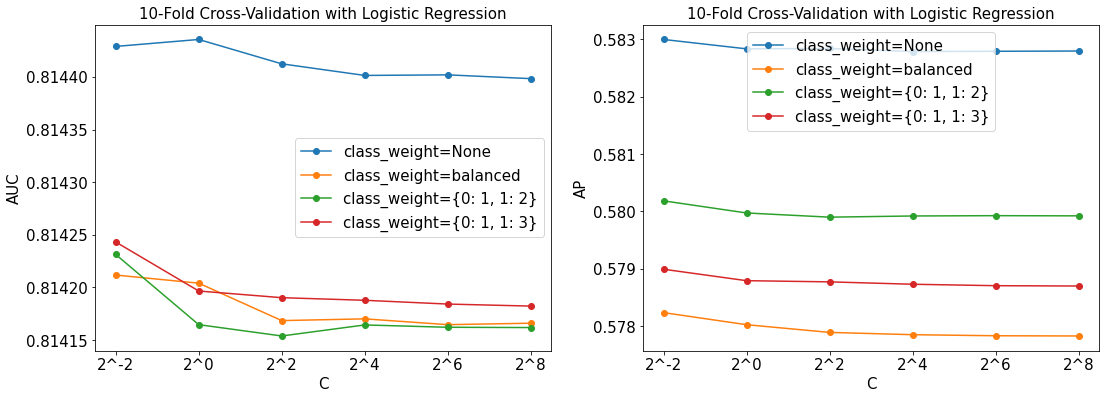

In [18]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold = 10)

## A-2. SVM

In [41]:
svm_clf = SVC(probability = True, kernel = 'rbf')   
model.model_selection_cv(svm_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.888211 (0.007424)
AUROC: 0.886944
AUPRC: 0.801521
Predicted classes: [0 1]
Confusion matrix:
 [[3791   26]
 [ 507  444]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      3817
           1       0.94      0.47      0.62       951

    accuracy                           0.89      4768
   macro avg       0.91      0.73      0.78      4768
weighted avg       0.89      0.89      0.87      4768

---------------------------------------------------------------------------


## Hyperparameter tuning- SVM

In [44]:
# Range of hyperparameters
params = {'C': [2**x for x in range(-2,11,2)], 
          'gamma': [2**x for x in range(-11,1,2)],
          'class_weight': [None, {0:1, 1:3},{0:1, 1:5},
                           {0:1, 1:7},{0:1, 1:10}]
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability = True, kernel = 'rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions = params, cv = 10,
                                 scoring = 'roc_auc', n_iter =200,
                                n_jobs = -1,random_state = 42, verbose = 1) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../src/model/svm_clf.pkl')

print('Best score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best score:  0.9700113289477903
Best parameters:  {'gamma': 0.5, 'class_weight': {0: 1, 1: 3}, 'C': 1}


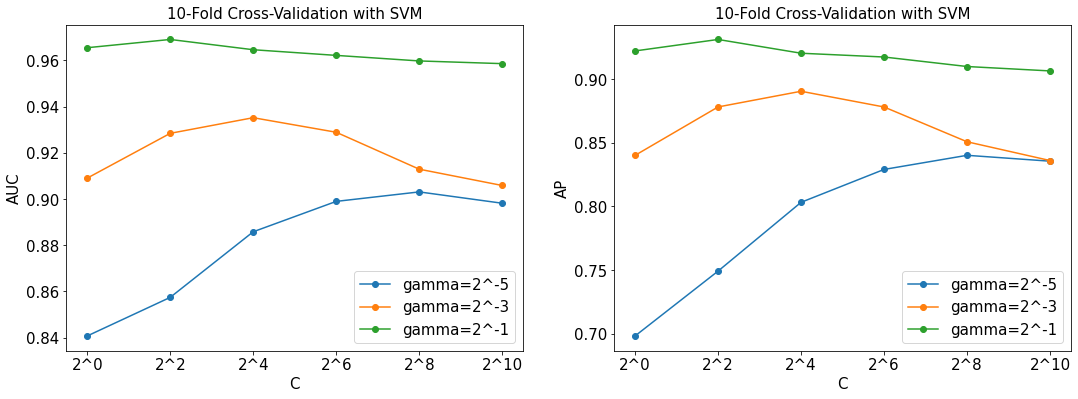

In [21]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold = 10)

## A-3. Random forest

In [16]:
rf_clf = RandomForestClassifier(random_state = 42)   
model.model_selection_cv(rf_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.921354 (0.013250)
AUROC: 0.967132
AUPRC: 0.900389
Predicted classes: [0 1]
Confusion matrix:
 [[3728   89]
 [ 286  665]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      3817
           1       0.88      0.70      0.78       951

    accuracy                           0.92      4768
   macro avg       0.91      0.84      0.87      4768
weighted avg       0.92      0.92      0.92      4768

---------------------------------------------------------------------------


## Hyperparameter tuning - RF

In [46]:
# Class ratio
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)

# Range of hyperparameters
params = {'n_estimators': [100, 300, 500, 1000],
        'max_features': [0.5, 1, 'sqrt', 'log2', None], 
        'max_depth': range(2,10,1),
        'class_weight': [None, 'balanced', 'balanced_subsample', 
                         {0: 1, 1: 2}, {0: 1, 1: class_ratio}]}

# Randomized search
rf_clf = RandomForestClassifier(random_state = 42)           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                   scoring = 'roc_auc', cv = 10, n_jobs = -1,n_iter = 200, 
                                   random_state = 42,verbose = 1).fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../src/model/rf_clf.pkl')

print('Best score:', rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best score: 0.9485140411027431
Best hyperparameters: {'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 9, 'class_weight': None}


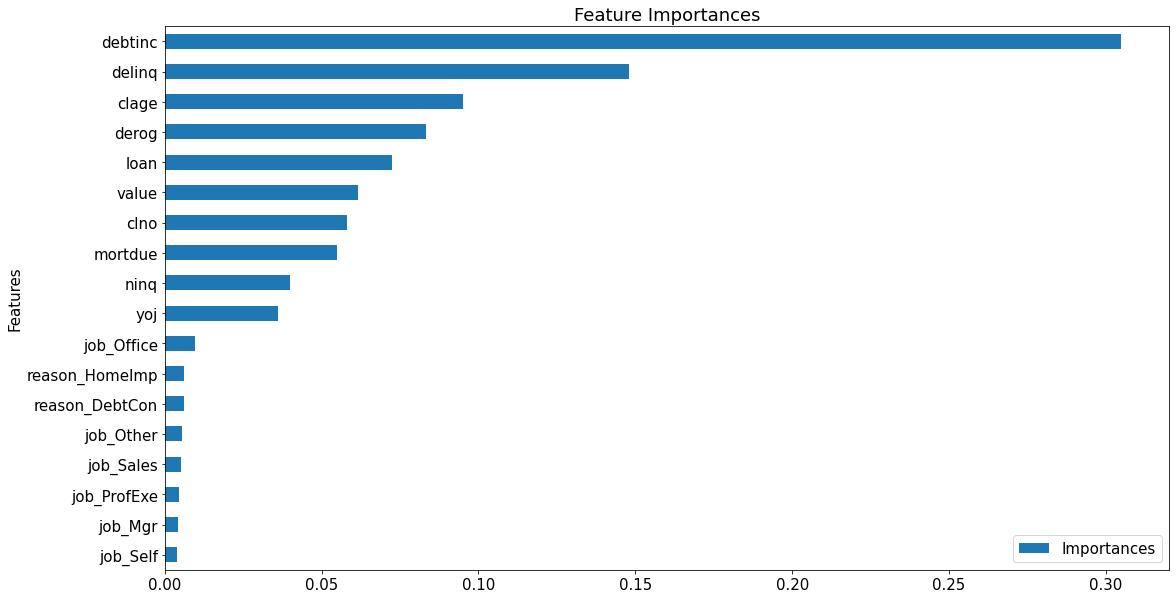

In [48]:
# Load trained model
rf_clf = joblib.load('../src/model/rf_clf.pkl')

# Compute feature importances
importances_df = pd.DataFrame({'Features': feat_nm, 
                               'Importances': rf_clf.feature_importances_})
# Plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.plot(kind='barh', figsize = (18,10))
plt.title('Feature Importances')
plt.savefig('../images/imp.png')

## A-4. XGBoost

In [61]:
xgb_clf = xgb.XGBClassifier(random_state = 42) 
model.model_selection_cv(xgb_clf, X_train_scaled, y_train, cv_fold = 10, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.898913 (0.011757)
AUROC: 0.931014
AUPRC: 0.825933
Predicted classes: [0 1]
Confusion matrix:
 [[3686  131]
 [ 351  600]]
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      3817
           1       0.82      0.63      0.71       951

    accuracy                           0.90      4768
   macro avg       0.87      0.80      0.83      4768
weighted avg       0.89      0.90      0.89      4768

---------------------------------------------------------------------------


## Hyperparameter tuning - XGB

In [73]:
import xgboost as xgb

# Class ratio
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)

params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'learning_rate': [0.01, 0.02, 0.05, 0.1]}


# Randomized search for XGB
xgb_clf =  xgb.XGBClassifier(objective = 'binary:logistic', 
                         scale_pos_weight = class_ratio, 
                         n_estimators = 2000)       
rsearch_xgb = RandomizedSearchCV(xgb_clf, param_distributions = params, n_iter = 200,  
                                  scoring = 'roc_auc', cv = 10, n_jobs = -1, 
                                  random_state = 42, verbose = 1)

# Fit the training set                                                       
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

print('Best score:', rsearch_xgb.best_score_) 
print('Best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best score: 0.9718474347068563
Best hyperparameters: {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.02, 'gamma': 0.04, 'colsample_bytree': 0.6}


# B. Test Prediction

In [65]:
# Load trained models
log_clf = joblib.load('../src/model/log_clf.pkl')
svm_clf = joblib.load('../src/model/svm_clf.pkl')
rf_clf = joblib.load('../src/model/rf_clf.pkl')
xgb_clf = joblib.load('../src/model/xgb_clf.pkl')

## B-0. Linear discriminant analysis

In [66]:
model.test_prediction(lda_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.836409
AUROC: 0.768036
AUPRC: 0.566092
Predicted classes: [0 1]
Confusion matrix:
 [[909  45]
 [150  88]]
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       954
           1       0.66      0.37      0.47       238

    accuracy                           0.84      1192
   macro avg       0.76      0.66      0.69      1192
weighted avg       0.82      0.84      0.82      1192

---------------------------------------------------------------------------


## B-1. Logistic regression

In [67]:
model.test_prediction(log_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.817114
AUROC: 0.770762
AUPRC: 0.565149
Predicted classes: [0 1]
Confusion matrix:
 [[867  87]
 [131 107]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       954
           1       0.55      0.45      0.50       238

    accuracy                           0.82      1192
   macro avg       0.71      0.68      0.69      1192
weighted avg       0.81      0.82      0.81      1192

---------------------------------------------------------------------------


## B-2. SVM

In [68]:
model.test_prediction(svm_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.946309
AUROC: 0.962498
AUPRC: 0.931291
Predicted classes: [0 1]
Confusion matrix:
 [[940  14]
 [ 50 188]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       954
           1       0.93      0.79      0.85       238

    accuracy                           0.95      1192
   macro avg       0.94      0.89      0.91      1192
weighted avg       0.95      0.95      0.94      1192

---------------------------------------------------------------------------


## B-3 Random Forest

In [69]:
model.test_prediction(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.890940
AUROC: 0.936015
AUPRC: 0.841367
Predicted classes: [0 1]
Confusion matrix:
 [[937  17]
 [113 125]]
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94       954
           1       0.88      0.53      0.66       238

    accuracy                           0.89      1192
   macro avg       0.89      0.75      0.80      1192
weighted avg       0.89      0.89      0.88      1192

---------------------------------------------------------------------------


## B-4. XGBoost

In [70]:
model.test_prediction(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.919463
AUROC: 0.963696
AUPRC: 0.896762
Predicted classes: [0 1]
Confusion matrix:
 [[922  32]
 [ 64 174]]
Classification report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       954
           1       0.84      0.73      0.78       238

    accuracy                           0.92      1192
   macro avg       0.89      0.85      0.87      1192
weighted avg       0.92      0.92      0.92      1192

---------------------------------------------------------------------------


## ROC and PR Curves

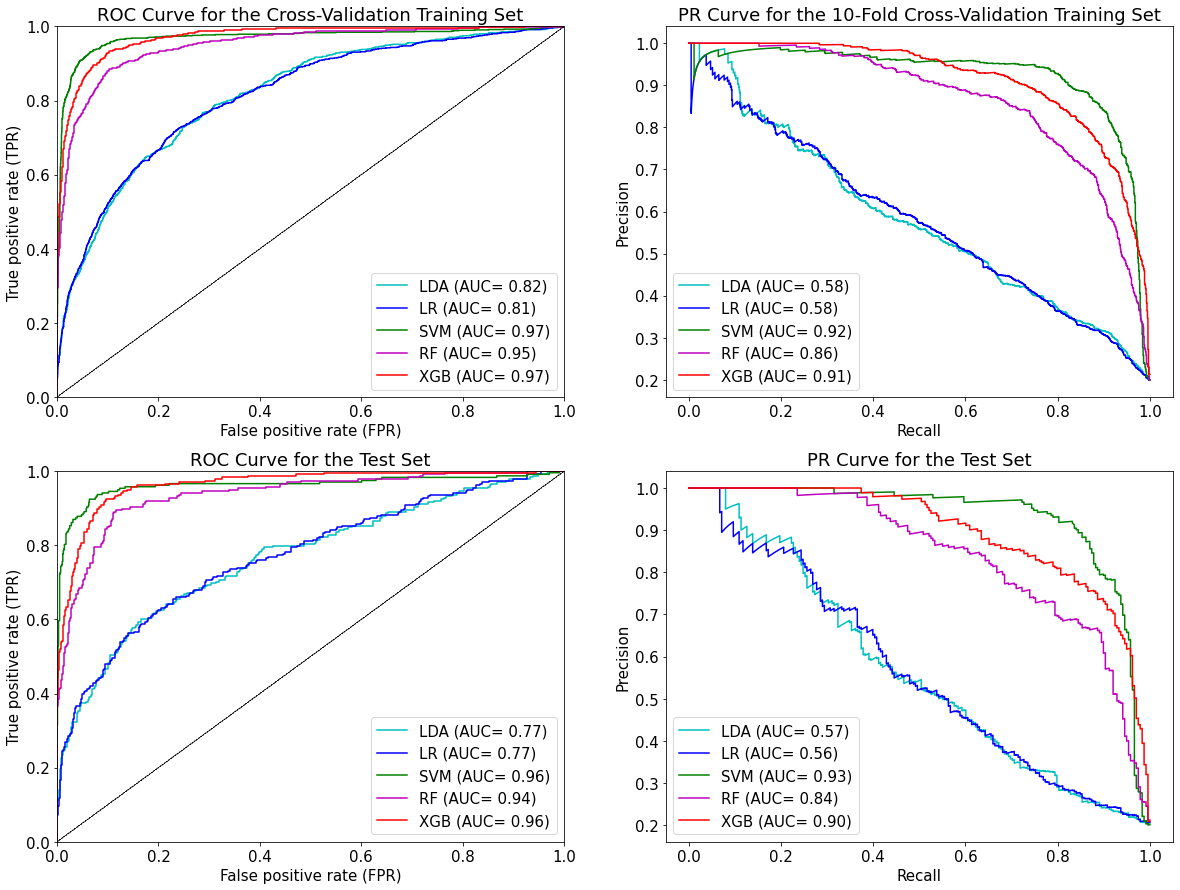

In [71]:
plt.figure(figsize = (20,15))

# LDA
model.plot_roc_pr_curves(lda_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                         cv_fold = 10, color= 'c', label= 'LDA (AUC= %0.2f)')

# LR
model.plot_roc_pr_curves(log_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                         cv_fold = 10, color= 'b', label= 'LR (AUC= %0.2f)')


# SVM
model.plot_roc_pr_curves(svm_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                         cv_fold = 10, color= 'g', label= 'SVM (AUC= %0.2f)')

# RF
model.plot_roc_pr_curves(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                         cv_fold = 10, color= 'm', label= 'RF (AUC= %0.2f)')

# XGB
model.plot_roc_pr_curves(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test,
                         cv_fold = 10, color= 'r', label= 'XGB (AUC= %0.2f)')

## AUC-ROC and AUC-PR for Cross-Validation vs. Test Sets

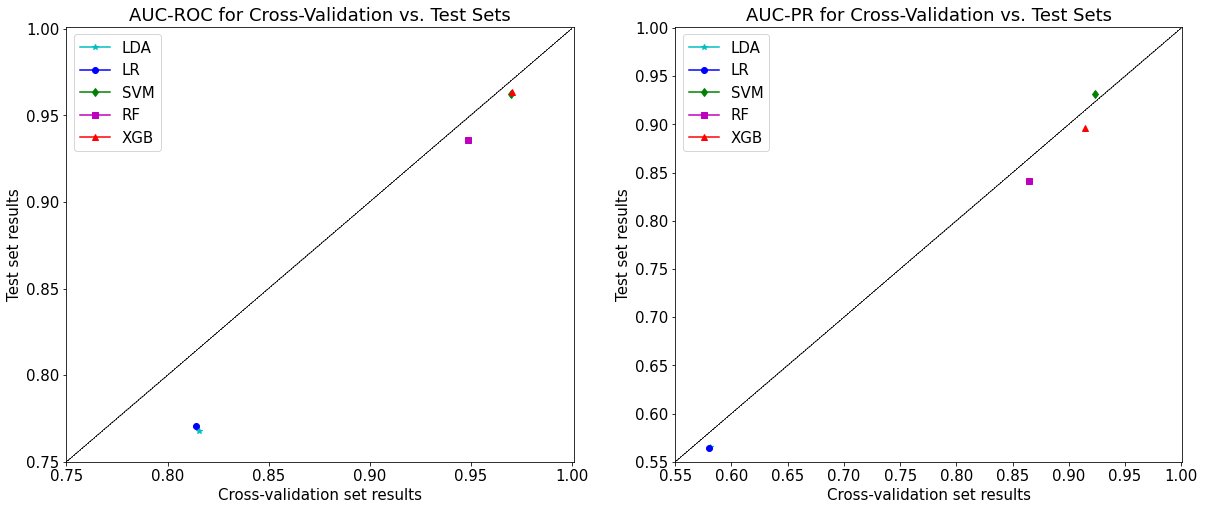

In [72]:
plt.figure(figsize = (20,8))

# LDA
model.plot_aucroc_aucpr(lda_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold = 10,  marker= "*", color = 'c', label = "LDA")

# LR
model.plot_aucroc_aucpr(log_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold = 10,  marker= "o", color = 'b', label = "LR")

# SVM
model.plot_aucroc_aucpr(svm_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold = 10,  marker= "d", color = 'g', label = "SVM")

# RF
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold = 10,  marker= "s", color = 'm', label = "RF")

# XGB
model.plot_aucroc_aucpr(xgb_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold = 10,  marker= "^", color = 'r', label = "XGB")

# Save figure
plt.savefig('../images/auc.png')